# Byggingagreining á gervitunglamyndum
Nathan HK

In [2]:
from pyrosm import OSM
from pyrosm import get_data

## Inngangsorð
Við viljum þjálfa gervigreindarlíkan til að greina byggingar á gervitunglamyndum. Við þurfum tvenn gögn: gervitunglamyndir og staðsetningar bygginga.

## Gervitunglamyndir (Í VINNSLU)
https://developers.google.com/maps/documentation/tile/satellite

## Staðsetningar bygginga
Ég sæki þessi gögn frá OpenStreetMap.

Downloaded Protobuf data 'iceland-latest.osm.pbf' (58.41 MB) to:
'/var/folders/k7/ssgp6zcs72j0lsw27nm39kvw0000gn/T/pyrosm/iceland-latest.osm.pbf'


<Axes: >

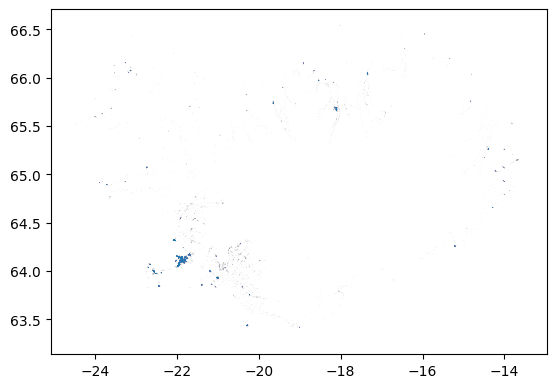

In [3]:
fp = get_data('Iceland')
osm = OSM(fp)
byggingar = osm.get_buildings()
byggingar.plot()

Hvað ef við viljum aðeins höfuðborgarsvæðið?

<Axes: >

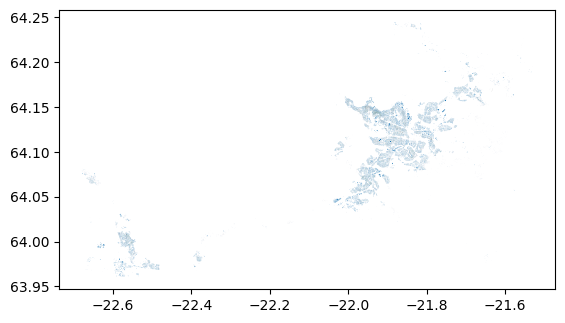

In [7]:
osm_hbs = OSM(fp, bounding_box=[-22.67910, 63.96095, -21.51676, 64.24443])
byggingar_hbs = osm_hbs.get_buildings()
byggingar_hbs.plot()

Innan á landamærum Seltjarnarness:

<Axes: >

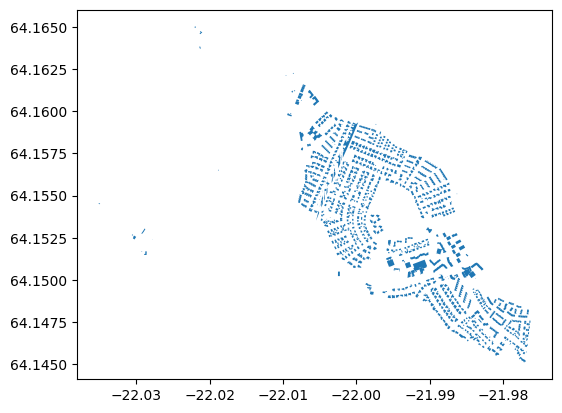

In [9]:
osm_stn = OSM(fp, bounding_box=osm.get_boundaries(name='Seltjarnarnes')['geometry'].values[0])
byggingar_stn = osm_stn.get_buildings()
byggingar_stn.plot()

Reykjahverfi í Mosfellsbæ:

<Axes: >

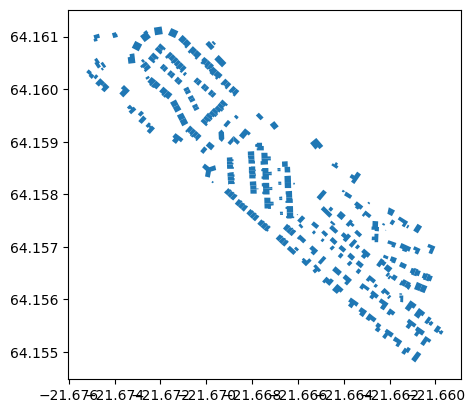

In [10]:
osm_mrh = OSM(fp, bounding_box=osm.get_boundaries(name='Reykjahverfi')['geometry'].values[0])
byggingar_mrh = osm_mrh.get_buildings()
byggingar_mrh.plot()

Form bygginganna eru sýnileg.

## Lokaorð
Við erum með forrit sem sækir formin allra bygginga í svæði með nákvæmum hnitum, og Google Maps veitir einfalda leið til að sækja gervitunglamyndir með nákvæmum hnitum. Við þurfum bara Google Maps-áskrift til að þjálfa líkan.